# Introduction

## Content:
1. [Variable Description](#1)
2. [Import Libraries](#2)
3. [Load the Dataset](#3)
4. [Exploratory Data Analysis](#4)
5. [Data Preprocessing](#5)
6. [Train Test Split](#6)
7. [Feature Scaling](#7)
8. [Random Forest Regression](#8)


<a id = 1></a>
# Variable Description

age: age of primary beneficiary (numerical)  
sex: gender(binary: female - male)  
bmi: body mass index  (numerical)
children: number of children covered by health insurance / number of dependents(numerical)
smoker: smoking  (binary: yes - no)
region: the beneficiary's residential area in the US (nominal: northeast - southeast - southwest - northwest)  
charges: Individual medical costs billed by health insurance (numerical)

Charges is the target, dependent variable.

<a id = 2></a>
# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

<a id = 3></a>
# Load the dataset

In [ ]:
df = pd.read_csv('../input/insurance/insurance.csv')

<a id = 4></a>
# Exploratory Data Analysis

In [ ]:
df.head()

In [ ]:
df.info()

## Statistical Analysis

In [ ]:
df.describe()

## Univariate Analysis

In [ ]:
for column in df.select_dtypes(include = ["float64", "int64"]):
  sns.distplot(df[column], color = "#b96f99")
  plt.grid(True)
  plt.show()

In [ ]:
df["age"].value_counts(normalize = True).head()

In [ ]:
(df["charges"] < 15000).value_counts(normalize = True).head()

Age and  children are discrete variables.  
bmi and charges are continuous variables. 

Above we can see that data is not evenly distributed. 
  * People with 0 children are more than others. So because of this, maybe model won't be good at predicting people with 4-5 children.
  * People who are 18 and 19 years old, are the majority.
  * In this dataset, charges are mostly between 1121 and 15000(%73 of our dataset)


## Correlation (Pearson)
This will show us linear correlation.

In [ ]:
correlation = df.corr()
correlation

In [ ]:
sns.heatmap(df.corr())
plt.show()

Let's see which features are correlated with charges:

In [ ]:
correlation["charges"].sort_values(ascending = False)

## Bivariate Analysis

In [ ]:
sns.pairplot(df)
plt.show()

## Outliers Detection

In [ ]:
for column in df.select_dtypes(include= ["float64", "int64"]).columns:
  plt.figure(figsize= (5,2))
  sns.boxplot(x= df[column], color = "#b96f99")
  plt.grid(True)
  plt.show()

As you can see above, in our target variable(charges), there are lots of outliers.

<a id = 5></a>
# Data Preprocessing

Firstly, let's check if there is null value or not.

In [ ]:
df.notnull().all()

There is no null value.

## Numerical Features

In this part, I will do imputing.
Even though there is no null value in this dataset, I will use imputer as if there is.

In [ ]:
from sklearn.impute import SimpleImputer

# Take numerical features, drop dependent variable.
df_num = df.select_dtypes(include= ["float64", "int64"])
df_num_features = df_num.drop("charges", axis = 1)
df_num_features_columns = list(df_num_features.columns)

#Use imputer with strategy median.
imputer = SimpleImputer(strategy = "median")
df_num_features = imputer.fit_transform(df_num_features)

#Add features back to our first DataFrame
df_num_features = pd.DataFrame(df_num_features, columns = df_num_features_columns)
df.drop(df_num_features.columns, axis = 1, inplace=True)
df = pd.concat([df, df_num_features], axis = 1)

## Categorical Features

In [ ]:
# take categorical features from our first DataFrame
df_cat = df.select_dtypes(include="object")

# See categories in each column.
for column in df_cat.columns:
  print(df_cat[column].value_counts())

For categorical feature called smoke, no is the majority.

### Encoding
I will use One Hot Encoder for categorical data.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

encoder = OneHotEncoder()
ct = ColumnTransformer([("encoder", OneHotEncoder(), df_cat.columns)])
X = encoder.fit_transform(df.drop(columns = ["charges"], axis = 1, inplace = False))

In [ ]:
# dependent variable
y = df["charges"].values

<a id = 6></a>
# Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

<a id = 7></a>
# Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train.todense())
X_test = sc.transform(X_test.todense())

<a id = 8></a>
# Random Forest Regression
In random forest regression, I will use grid search to tune hyperparameters.  
GridSearchCV will evaluate all the possible combinations of hyperparameters using cross-validation. That's why it requires utility function to score.  
The utility function is neg_mean_squared_error here.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators':[40, 50, 100, 200, 300], 'max_features':[6, 8, 10, 15]}, 
              {'bootstrap':[False], 'n_estimators': [3, 10], 'max_features': [2, 3,  4]}]

rf_reg = RandomForestRegressor()

grid_search = GridSearchCV(rf_reg, param_grid, cv= 5, scoring = 'neg_mean_squared_error', return_train_score = True)

grid_search.fit(X_train, y_train)

In [ ]:
#Parameters of best result
print(grid_search.best_params_)

#Best Estimator
rf_reg = grid_search.best_estimator_

See result of each combination:

In [ ]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  #Since I used neg_mean_squared_error, we need to add minus before mean_score.
  print(np.sqrt(-mean_score), params)

In [ ]:
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

### Mean Squared Error
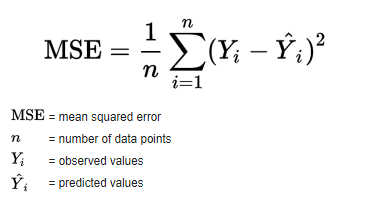

In [ ]:
from sklearn.metrics import mean_squared_error

rf_mse = mean_squared_error(y_test, y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_rmse

### K-fold cross validation

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10)
rf_rmse_scores = np.sqrt(-scores)
print(rf_rmse_scores)

print("Mean:" , rf_rmse_scores.mean())
print("Standard Deviation:", rf_rmse_scores.std())

### R2 score
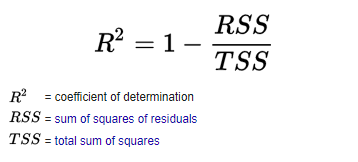

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)